In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


/kaggle/input/ba-reviews/ba.png
/kaggle/input/ba-reviews/BA_reviews.csv


In [136]:
import requests

In [3]:
data = pd.read_csv('Dataset/BA_reviews.csv')
data.drop("ID", inplace=True, axis = 1)
data['verified?'] = data['reviews'].apply(lambda x: x.split('|')[0])
data ['reviews'] = data['reviews'].apply(lambda x: x.split('|')[1])
data.loc[data['verified?'] != '✅ Trip Verified ','verified?'] = 'Not Verified'
data.loc[data['verified?'] == '✅ Trip Verified ','verified?'] = 'Trip Verified'

In [4]:
data['verified?'].value_counts()

Trip Verified    829
Not Verified     171
Name: verified?, dtype: int64

In [79]:
import re, nltk, spacy, gensim
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from pprint import pprint

# Plotting tools
import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """


In [82]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data['review_text'].tolist()))

print(data_words[:1])

[['worst', 'ever', 'life', 'wanted', 'pamper', 'bought', 'business', 'class', 'looking', 'forward', 'experience', 'mention', 'chaos', 'changing', 'gate', 'several', 'time', 'thing', 'happen', 'surprised', 'lack', 'attention', 'passenger', 'delayed', 'almost', 'hour', 'even', 'though', 'staff', 'offered', 'voucher', 'idea', 'told', 'minute', 'boarding', 'already', 'begun', 'firstly', 'anyone', 'voucher', 'secondly', 'even', 'able', 'finally', 'airport', 'another', 'waiting', 'minute', 'cross', 'check', 'meantime', 'told', 'problem', 'load', 'food', 'without', 'food', 'board', 'food', 'offered', 'given', 'everyone', 'plane', 'small', 'nut', 'business', 'class', 'passenger', 'offered', 'drink', 'business', 'class', 'contained', 'small', 'glass', 'juice', 'received', 'apology', 'compensation', 'company', 'disgraceful', 'cheap', 'service', 'expensive', 'price']]


In [84]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['bad ever life want pamper buy business class look forward experience mention chaos change gate several time thing happen surprised lack attention passenger delay almost hour even staff offer voucher idea tell minute boarding already begin firstly voucher secondly even able finally airport waiting minute cross check meantime tell problem load food food board food offer give plane small business class passenger offer drink business class contain small glass juice receive apology compensation company disgraceful cheap service expensive price', 'seem race bottom airline even check require submission document covid restriction however form start submission process hopelessly break click submit form hang forever error message give try different browser different device hang mean check online select seat try use minute click thought donate enough time']


In [85]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [86]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  4.1318987341772155 %


In [116]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=4,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model) 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [117]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,dominant_topic
Doc0,0.000000,0.420000,0.240000,0.330000,1
Doc1,0.010000,0.010000,0.010000,0.970000,3
Doc2,0.050000,0.000000,0.090000,0.860000,3
Doc3,0.010000,0.720000,0.010000,0.260000,1
Doc4,0.010000,0.840000,0.150000,0.010000,1
Doc5,0.010000,0.200000,0.010000,0.770000,3
Doc6,0.010000,0.560000,0.160000,0.270000,1
Doc7,0.000000,0.910000,0.000000,0.090000,1
Doc8,0.010000,0.910000,0.010000,0.080000,1
Doc9,0.010000,0.340000,0.010000,0.640000,3


In [138]:
df_document_topic.shape

(1000, 5)

In [145]:
topics_ = df_document_topic['dominant_topic'].tolist()

In [146]:
data['topic'] = topics_

In [147]:
data.head()

,reviews,verified?,sentiment,confidence,review_text,topic
0,This flight was one of the worst I have ever...,Trip Verified,NEGATIVE,0.999010,worst ever life wanted pamper bought business ...,1
1,It seems that there is a race to the bottom a...,Not Verified,NEGATIVE,0.999618,seems race bottom amongst airline cannot even ...,3
2,As a Spanish born individual living in Engla...,Not Verified,NEGATIVE,0.999037,spanish born individual living england using a...,3
3,"A rather empty and quiet flight to Tel Aviv,...",Trip Verified,NEGATIVE,0.711952,rather empty quiet aviv friendly cabin crew em...,1
4,Easy check in and staff member was polite an...,Trip Verified,POSITIVE,0.991932,easy check staff member polite helpful made sp...,1


<AxesSubplot:xlabel='topic'>

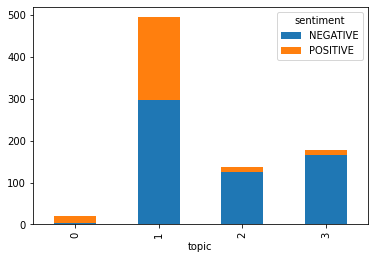

In [157]:
data[data['verified?'] == 'Trip Verified'].groupby(['topic'])['sentiment'].value_counts().unstack().plot.bar(stacked=True)

In [119]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -248732.7813630342
Perplexity:  434.1835357168686
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 4,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [120]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,573
1,3,233
2,2,169
3,0,25


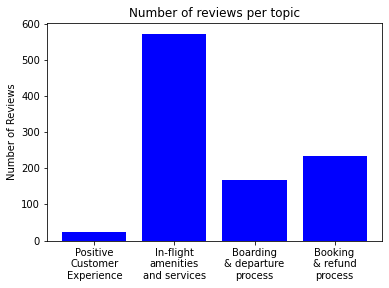

In [135]:
plt.bar(range(1,5,1),[25,573,169,233], color="blue")
plt.ylabel("Number of Reviews")
plt.title("Number of reviews per topic")
x_labels = (["Positive\nCustomer\nExperience", "In-flight\namenities\nand services",
            "Boarding\n& departure\nprocess","Booking\n& refund\nprocess"])
plt.xticks(range(1,5), x_labels)
# Show the graph
plt.show()

In [122]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,able,absolutely,accept,acceptable,access,accord,actually,add,additional,address,...,wish,wonderful,word,work,world,worth,write,wrong,year,young
Topic0,0.485414,4.766681,0.334590,0.265374,0.264949,0.264492,0.265701,0.256390,0.289986,0.264665,...,17.135266,13.305077,0.252702,0.350054,0.257669,0.291190,10.409326,0.258632,3.608830,0.267468
Topic1,18.470789,8.852076,8.540862,17.196739,22.471208,7.224829,28.868481,6.982890,7.247436,5.555612,...,0.510150,11.524593,7.755100,117.125961,105.940419,32.820816,5.560431,0.547954,69.750714,11.721118
Topic2,5.551816,13.219967,1.857356,5.153389,4.320340,0.820178,5.087432,9.424562,1.518099,0.351252,...,1.744539,0.268156,0.438011,8.482722,0.452453,13.439619,0.852101,12.415798,14.369850,1.746585
Topic3,37.811914,8.019163,17.219357,0.256729,3.067657,4.543534,13.113118,0.799715,28.198211,10.416791,...,1.210388,0.261760,4.579018,47.721650,11.483032,0.706381,12.565236,25.131686,54.349220,2.047054


In [123]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,thank,home,amazing,service,great,staff,airway,helpful,help,customer,wish,airline,make,fly,wonderful
Topic 1,seat,food,good,crew,service,cabin,class,time,business,drink,meal,offer,economy,lounge,club
Topic 2,seat,hour,check,passenger,plane,staff,delay,luggage,boarding,gate,arrive,tell,service,airport,wait
Topic 3,customer,service,book,cancel,hour,tell,time,airway,say,refund,travel,ticket,phone,voucher,flight


/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [5]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

2023-01-23 18:40:31.320610: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [6]:
data['sentiment'] = data['reviews'].apply(lambda x: sentiment_pipeline(x, max_length=512, truncation=True)[0]["label"])
data['confidence'] = data['reviews'].apply(lambda x: sentiment_pipeline(x, max_length=512, truncation=True)[0]["score"])

In [10]:
data.to_csv('df.csv')

In [11]:
data.head(5)

,reviews,verified?,sentiment,confidence
0,This flight was one of the worst I have ever...,Trip Verified,NEGATIVE,0.999010
1,It seems that there is a race to the bottom a...,Not Verified,NEGATIVE,0.999618
2,As a Spanish born individual living in Engla...,Not Verified,NEGATIVE,0.999037
3,"A rather empty and quiet flight to Tel Aviv,...",Trip Verified,NEGATIVE,0.711952
4,Easy check in and staff member was polite an...,Trip Verified,POSITIVE,0.991932


In [12]:
data['sentiment'].value_counts()

NEGATIVE    715
POSITIVE    285
Name: sentiment, dtype: int64

In [13]:
data.groupby('verified?')['sentiment'].value_counts()

verified?      sentiment
Not Verified   NEGATIVE     126
               POSITIVE      45
Trip Verified  NEGATIVE     589
               POSITIVE     240
Name: sentiment, dtype: int64

<AxesSubplot:xlabel='verified?'>

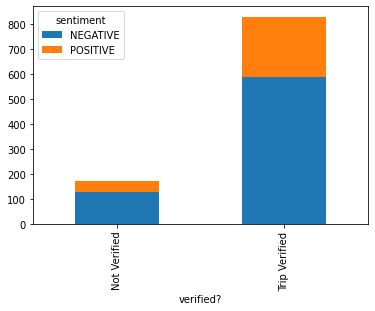

In [78]:
data.groupby('verified?')['sentiment'].value_counts().unstack().plot.bar(stacked=True)

In [14]:
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk import FreqDist

In [36]:
import string
from nltk.corpus import stopwords

# Convert to lower case
data['review_text'] = data['reviews'].str.lower()

# Remove punctuation and numbers
data['review_text'] = data['review_text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation + string.digits)))

# Remove stop words
stop_words = stopwords.words("english")
stop_words.extend(['british','airway','airline','ba','flight'])
stop_words = set(stop_words)
data['review_text'] = data['review_text'].apply(lambda x: " ".join(word for word in x.split() if word.lower() not in stop_words))


# Perform lemmatization 
lemmatizer = WordNetLemmatizer()
data['review_text'] = data['review_text'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) 
                                                                    for word in x.split() if len(word)> 3]))

In [58]:
# Get bigrams and their frequency
bigrams = list(ngrams(data[data['sentiment'] == 'POSITIVE']['review_text'].str.cat(sep=' ').split(), 2))
bigrams_fd = FreqDist(bigrams)

In [70]:
bigrams_fd = {'_'.join(bigram): freq for bigram, freq in bigrams_fd.items()}

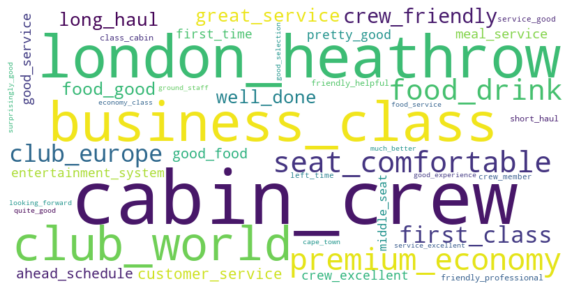

In [74]:
wordcloud = WordCloud(width=800, height=400, min_font_size = 10, background_color ='white',)
# Generate the word cloud
wordcloud.generate_from_frequencies(bigrams_fd)

# Show the word cloud
plt.figure(figsize=(10,10), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [75]:
# Get bigrams and their frequency
bigrams_ng = list(ngrams(data[data['sentiment'] == 'NEGATIVE']['review_text'].str.cat(sep=' ').split(), 2))
bigrams_fd_ng = FreqDist(bigrams_ng)
bigrams_fd_ng = {'_'.join(bigram): freq for bigram, freq in bigrams_fd_ng.items()}

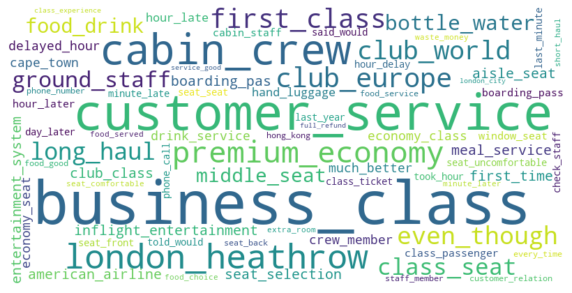

In [76]:
wordcloud = WordCloud(width=800, height=400, min_font_size = 10, background_color ='white',)
# Generate the word cloud
wordcloud.generate_from_frequencies(bigrams_fd_ng)

# Show the word cloud
plt.figure(figsize=(10,10), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()